* This notebook contains __Writeup Template__


# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
### Finding Lane Lines on the Road

The goals / steps of this project are the following : 

* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report

---

## Describe pipeline


My pipeline use 3-step approach to find the lane lines.

* Generate rough lines using canny edge detection with grayscaled image
* Convert the edges into Hough space and fit the left and right line
* Using color filtered image, determine the color of line (white/yellow)


---

#### Step 1. Edge detection

To find the lines from image, I used bulit-in/library functions introduced in the class.
First, target imaged is converted into grayscale using helper function `grayscale`, and Canny edge detection is applied to specify edges.

Tuning parameters for `GaussianBlur` and `Canny` from `cv2` as follows:
```
kernel_size = 7
low_threshold = 70
high_threshold = 150
```

#### Step 2. Finding lines with Hough Transform

`HoughlinesP` function convert the points on xy-plane into lines on Hough space. Every single point will be represented as a straight line on Hough plane. The intersections of those lines means lines on xy-plane. Prams. and options used in this step are:
```
rho = 1 # 
theta = np.pi*1/180 
threshold = 30    
min_line_length = ysize/5 
max_line_gap = 200  
```

`cv2.HoughlinesP` gives a number of lines which satisfy given constraints, so I need to filter out unnecessary lines that does'nt represent correct lane lines. In this project, a simple restriction of area and slope works fine. I set the region of interest, and get rid of lines looked horizontal. Next, distinguish between left and right line is done by check the sign of slope.

```
max_slope = 0.8*ysize/xsize
lines_left=[]
lines_right=[]
for line in lines:
    slope = (line[0][1]-line[0][3])/(line[0][0]-line[0][2])
    if abs(slope) > max_slope:
        if slope < 0:
            line_ext=np.array([math.floor((ysize*0.6-(line[0][3]-slope*line[0][2]))/slope), math.floor(ysize*0.6),
            math.floor((ysize-(line[0][3]-slope*line[0][2]))/slope), ysize ])
            lines_left.append([line_ext])
        else:
            line_ext=np.array([math.floor((ysize*0.6-(line[0][3]-slope*line[0][2]))/slope), math.floor(ysize*0.6),
            math.floor((ysize-(line[0][3]-slope*line[0][2]))/slope), ysize])
            lines_right.append([line_ext])
                    

lines_left = np.asarray(lines_left)
lines_right = np.asarray(lines_right)

line_left = np.mean(lines_left, axis = 0)
line_right = np.mean(lines_right, axis = 0)
```

#### Step 3. Check the color of line

To separate _YELLOW_ lines from white line, the color selection method is used. The pure yellow is `[255 255 0]` in rgb, that means checking wheter the line contains blue colors or not can give us clues. To make it practical, the blue color thresholded image is processed into set of lines with step 1 and 2.
And then, by trying to match left and right lines from step 2 with blue lines, the yellow colored lines can be detected.

```
    flag_left=0
    for blueline in lines_blue:
        for x1b,y1b,x2b,y2b in blueline:
            blueslope = (y2b-y1b) / (x2b-x1b)
            bluedist = (abs(-slope_left*x1b+y1b-offset_left) + 
            abs(-slope_left*x2b+y2b-offset_left)) / math.sqrt(slope_left**2 + 1)
            if (abs(blueslope)-abs(slope_left)<0.05):
                if bluedist < 30:
                    flag_left=1
                    break
        if flag_left==1:
            break
            
    if flag_left==1:
        cv2_line(line_image_test, (line_selected[0][0][0], line_selected[0][0][1]), 
        (line_selected[0][0][2], line_selected[0][0][3]), (255,0,0),10)
    else:
        cv2_line(line_image_test, (line_selected[0][0][0], line_selected[0][0][1]), 
        (line_selected[0][0][2], line_selected[0][0][3]), (255,255,0),10)

            
    flag_right=0
    for blueline in lines_blue:
        for x1b,y1b,x2b,y2b in blueline:
            blueslope = (y2b-y1b) / (x2b-x1b)
            bluedist = (abs(-slope_right*x1b+y1b-offset_right) + 
            abs(-slope_right*x2b+y2b-offset_right)) / math.sqrt(slope_right**2 + 1)
            if (abs(blueslope)-abs(slope_right)<0.05):
                if bluedist < 30:
                    flag_right=1
                    break            
        if flag_right==1:
            break
            
    if flag_right==1:
        cv2_line(line_image_test, (line_selected[1][0][0], line_selected[1][0][1]), 
        (line_selected[1][0][2], line_selected[1][0][3]), (255,0,0),10)
    else:
        cv2_line(line_image_test, (line_selected[1][0][0], line_selected[1][0][1]), 
        (line_selected[1][0][2], line_selected[1][0][3]), (255,255,0),10)
```



## Potential shortcomings

* Thresholds of edge detection is fixed. Detecting performance might varying with the contrast of given image
* Curved line cannot be detected, since `HoughlineP` gives straight lines.
* Splitted brigtness gives wrong result.
* __(IMPORTANT) Incoding video stucks when the pipeline gives no lines to draw__, and this is from `cv2.line` only can handle nonzero type input. Exception handling must be required, but this time it remains as a bug due to my lack of python experience. 
    - because of this problem, extra.mp4 stops in the middle.

## Possible improvements

* Considering original quality of image, like brightness, contrast, color space, etc., can make the performance better.
* Using previous state of detected line makes the pipeline more stable. (like many causal filters)

## Import Packages

In [1]:
%config InlineBackend.figure_format ='retina'

#importing some useful packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


plt.rcParams['figure.figsize'] = 16,9 

## Read in an Image

In [2]:
#reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('challenge.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


## Ideas for Lane Detection Pipeline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    I did not use draw_lines function.
    All the features are included in "process_image"
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.


    # Define image properties
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    apex = [xsize/2, ysize/2]


    # Define the area of interest from the original image
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    XX, YY = np.meshgrid(np.arange(0,xsize), np.arange(0,ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) &\
                        (YY > (XX*fit_right[0] + fit_right[1])) &\
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
            
    # Check the selected region
    plt.imshow(image)
    x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
    # Find mean value of RGBs
    mean_rgb = 0

    for i in range(xsize):
        for j in range(ysize):
            mean_rgb = mean_rgb + sum(image[j, i])*region_thresholds[j, i]

    mean_rgb=mean_rgb//(3*np.sum(region_thresholds))

    # Define color selection criteria
    red_threshold = 2.2*mean_rgb;
    green_threshold = 2.2*mean_rgb;
    blue_threshold = 2.2*mean_rgb;

    rgb_threshold = [ red_threshold, green_threshold, blue_threshold ]
    color_thresholds = [ image[:,:,0] < rgb_threshold[0], image[:,:,1] < rgb_threshold[1], image[:,:,2] < rgb_threshold[2] ]

    # Mask color and region
    red_select = np.copy(image)
    green_select = np.copy(image)
    blue_select = np.copy(image)

    red_select[color_thresholds[0] | ~region_thresholds ] = [0, 0, 0]
    green_select[color_thresholds[1] | ~region_thresholds ] = [0, 0, 0]
    blue_select[color_thresholds[2] | ~region_thresholds ] = [0, 0, 0]

    red_select=red_select[:,:,0]
    green_select=green_select[:,:,1]
    blue_select=blue_select[:,:,2]



    # Convert to grayscale

    gray = grayscale(image)

    # Define Gaussian smoothing & Canny parameters

    kernel_size = 7
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    low_threshold = 70
    high_threshold = 150
    edges  = cv2.Canny(blur_gray, low_threshold, high_threshold)

    edge_select=np.copy(edges)
    edge_select[ ~region_thresholds ] = 0

    # Apply Hough Transform to find Lane Lines
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi*1/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = ysize/5 #minimum number of pixels making up a line
    max_line_gap = 200   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    line_image_red = np.copy(image)*0
    line_image_green = np.copy(image)*0
    line_image_blue = np.copy(image)*0

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edge_select, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edge_select, edge_select, edge_select)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    lines_blue = cv2.HoughLinesP(blue_select, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines_blue:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image_blue,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((blue_select, blue_select, blue_select)) 

    # Draw the lines on the edge image
    lines_edges_blue = cv2.addWeighted(color_edges, 0.8, line_image_blue, 1, 0) 

    max_slope = 0.8*ysize/xsize

    lines_left=[]
    lines_right=[]
    for line in lines:
        slope = (line[0][1]-line[0][3])/(line[0][0]-line[0][2])
        if abs(slope) > max_slope:
            if slope < 0:
                line_ext=np.array([math.floor((ysize*0.6-(line[0][3]-slope*line[0][2]))/slope), math.floor(ysize*0.6), math.floor((ysize-(line[0][3]-slope*line[0][2]))/slope), ysize ])
                lines_left.append([line_ext])
            else:
                line_ext=np.array([math.floor((ysize*0.6-(line[0][3]-slope*line[0][2]))/slope), math.floor(ysize*0.6), math.floor((ysize-(line[0][3]-slope*line[0][2]))/slope), ysize])
                lines_right.append([line_ext])
                    

    lines_left = np.asarray(lines_left)
    lines_right = np.asarray(lines_right)

    line_left = np.mean(lines_left, axis = 0)
    line_right = np.mean(lines_right, axis = 0)

    slope_left = (line_left[0][1]-line_left[0][3])/(line_left[0][0]-line_left[0][2])
    slope_right = (line_right[0][1]-line_right[0][3])/(line_right[0][0]-line_right[0][2])
    offset_left = math.floor((line_left[0][3]-slope_left*line_left[0][2]))
    offset_right = math.floor((line_right[0][3]-slope_right*line_right[0][2]))

    line_params = [ slope_left, slope_right, offset_left, offset_right]

    line_selected=np.asarray([line_left.astype(int), line_right.astype(int)])

    line_image_test=np.copy(image)

    flag_left=0
    for blueline in lines_blue:
        for x1b,y1b,x2b,y2b in blueline:
            blueslope = (y2b-y1b) / (x2b-x1b)
            bluedist = (abs(-slope_left*x1b+y1b-offset_left) + abs(-slope_left*x2b+y2b-offset_left)) / math.sqrt(slope_left**2 + 1)
            if (abs(blueslope)-abs(slope_left)<0.05):
                if bluedist < 30:
                    flag_left=1
                    break
        if flag_left==1:
            break
            
    if flag_left==1:
        cv2.line(line_image_test, (line_selected[0][0][0], line_selected[0][0][1]), (line_selected[0][0][2], line_selected[0][0][3]), (255,0,0),10)
    else:
        cv2.line(line_image_test, (line_selected[0][0][0], line_selected[0][0][1]), (line_selected[0][0][2], line_selected[0][0][3]), (255,255,0),10)

            
    flag_right=0
    for blueline in lines_blue:
        for x1b,y1b,x2b,y2b in blueline:
            blueslope = (y2b-y1b) / (x2b-x1b)
            bluedist = (abs(-slope_right*x1b+y1b-offset_right) + abs(-slope_right*x2b+y2b-offset_right)) / math.sqrt(slope_right**2 + 1)
            if (abs(blueslope)-abs(slope_right)<0.05):
                if bluedist < 30:
                    flag_right=1
                    break            
        if flag_right==1:
            break
            
    if flag_right==1:
        cv2.line(line_image_test, (line_selected[1][0][0], line_selected[1][0][1]), (line_selected[1][0][2], line_selected[1][0][3]), (255,0,0),10)
    else:
        cv2.line(line_image_test, (line_selected[1][0][0], line_selected[1][0][1]), (line_selected[1][0][2], line_selected[1][0][3]), (255,255,0),10)

    lines_edges_test = cv2.addWeighted(color_edges, 0.8, line_image_test, 1, 0) 
    plt.imshow(lines_edges_test)
    plt.show()


    return lines_edges_test

Let's try the one with the solid white lane on the right first ...

<IPython.core.display.Javascript object>


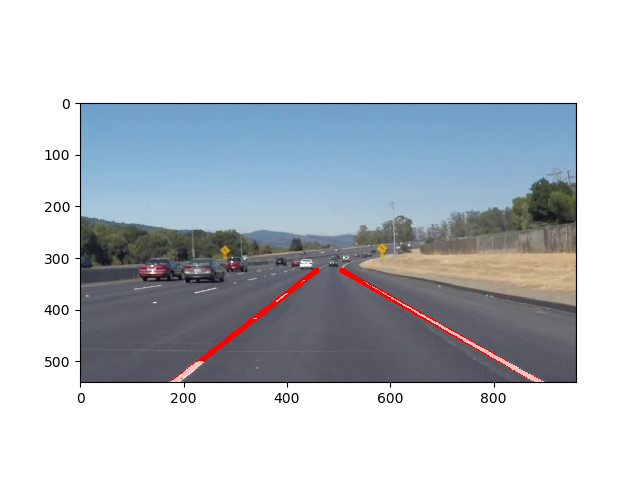

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [06:53<00:01,  1.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11min 45s, sys: 2.02 s, total: 11min 47s
Wall time: 6min 54s


In [7]:
%matplotlib notebook
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [20:47<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 35min 38s, sys: 5.98 s, total: 35min 44s
Wall time: 20min 48s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
%matplotlib notebook
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))